In [1]:
### https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression
import numpy as np
import pandas as pd 
# classifier models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
# scaler
from sklearn.preprocessing import StandardScaler
# split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
# matplot libs
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt 
# to reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# scoring
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
# to classification report
from sklearn.model_selection import learning_curve
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

Abaixo, funcoes de plots (ou tentativas rs) de plotar o gráfico. O último que postei era essa primeira funcao. Este comentário será apagado em 24 horas, boa noite.

In [2]:
def print_dim_reduced_data(samples_2d, targets):
    target_ids = range(2)
    colors = 'r', 'g'
    for i, c, label in zip(target_ids, colors, targets):
        plt.scatter(samples_2d[targets == i, 0], samples_2d[targets == i, 1], c=c, label=label)
    plt.grid(linestyle='--')
    plt.legend(bbox_to_anchor=(1.15, 0.725, 0, 0))
    plt.show()
    plt.close()

In [9]:
import warnings
# https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi
warnings.filterwarnings('ignore')

def print_val_scores(model, X_train, y_train, scoring=['f1_weighted','f1_macro','recall_weighted',
                                                       'precision_weighted'], 
                     cv=10):
    _,__,f1_w,f1_m,r,p=cross_validate(model, X_train, y_train, cv=cv,
                       scoring=scoring).items()
    mean_f1_w = f1_w[1].mean(); sd_f1_w = f1_w[1].std()
    mean_f1_m = f1_m[1].mean(); sd_f1_m = f1_m[1].std()
    mean_r = r[1].mean(); sd_r = r[1].std()
    mean_p = p[1].mean(); sd_p = p[1].std()
    
    print("Classification report for classifier {}:\nparameters:\n".format(model) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_w[0],mean_f1_w,sd_f1_w) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_m[0],mean_f1_m,sd_f1_m) +
          "{}\nmean: {}, std deviation: {}\n\n".format(r[0],mean_r,sd_r) +
          "{}\nmean: {}, std deviation: {}\n\n".format(p[0],mean_p,sd_p))

In [10]:
def print_val_custom_score (model, X_train, y_train, 
                            scoring='f1_macro', 
                            cv=10):
    print("Classification report for classifier {}:\nparameters:\n".format(model))
    
    myReturn=cross_validate(model,X_train,y_train,cv=cv,scoring=scoring)
    _,__,metric_score=myReturn
    metric_score=myReturn[metric_score]
    mean = np.mean(metric_score)
    sd = np.std(metric_score)
    print("{}\nmean: {}, std deviation: {}\n\n".format(scoring,mean,sd))

In [11]:
def print_metrics(clf, X, y, prediction):
    print(f"Classification report for classifier {clf}:\n"
          f"{metrics.classification_report(y, prediction)}\n")
    disp = metrics.plot_confusion_matrix(clf, X, y)
    disp.figure_.suptitle("Confusion Matrix")

In [12]:
data=pd.read_csv('heart_pred.csv')
# data.describe()

Retirando valores nulos e NaN

In [13]:
data=data.dropna()
# data_columns=list(data.columns.values.tolist())
data=data[data.notnull()]
data=data.reset_index()
data=data.sample(frac=0.1)
data.describe()

,index,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2137.221311,0.387978,49.898907,1.920765,0.382514,7.442623,0.024590,0.019126,0.314208,0.019126,238.614754,133.648907,82.807377,25.986393,74.942623,80.953552,0.161202
std,1225.679201,0.487957,8.465443,1.007781,0.486666,12.052885,0.155084,0.137154,0.464835,0.137154,44.681910,21.442126,12.304712,4.384681,11.958581,19.545956,0.368221
min,16.000000,0.000000,33.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,148.000000,85.500000,51.000000,15.540000,44.000000,40.000000,0.000000
25%,1044.250000,0.000000,42.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,208.000000,118.125000,75.000000,23.035000,67.000000,70.000000,0.000000
50%,2166.000000,0.000000,50.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,235.000000,131.000000,82.000000,25.625000,75.000000,77.000000,0.000000
75%,3131.750000,1.000000,57.000000,2.750000,1.000000,15.000000,0.000000,0.000000,1.000000,0.000000,261.750000,146.375000,89.375000,28.195000,80.000000,87.000000,0.000000
max,4200.000000,1.000000,69.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,410.000000,207.000000,132.000000,56.800000,130.000000,244.000000,1.000000


In [14]:
y=data["TenYearCHD"]
X=data.drop('TenYearCHD',axis=1)

In [15]:
# X = TSNE(n_components=2).fit_transform(X)
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [16]:
X_reduced=pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = 200)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

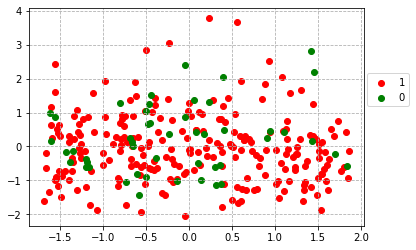

In [18]:
# print data distribution after t-SNE reduction
print_dim_reduced_data(X_train, y_train)
# print_2d_data(X_train, y_train)

In [22]:
f_beta = make_scorer(fbeta_score, beta=2, average='weighted',zero_division=0)

In [67]:
# Criacao de grid para a Random Forest Classifier
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)

grid_rfc = {
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 11)],
    'criterion': ['gini','entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': max_depth,
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [68]:
clf_rfc = RandomForestClassifier()

In [69]:
#  Random search of parameters. Uses our shuffle selection cross validation, 
#  and search across "n_iter" different (shuffle) combinations, and use all available cores
rfc_search = RandomizedSearchCV(estimator = clf_rfc, param_distributions = grid_rfc, 
                               n_iter = 20, cv = 5, random_state=200, scoring=f_beta)

rfc_search.fit(X_train, y_train)
rfc_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': True}

In [70]:
rfc_search.best_score_

0.8040294578297871

In [71]:
best_clf_rfc = rfc_search.best_estimator_
print_val_scores(best_clf_rfc, X_train, y_train)

Classification report for classifier RandomForestClassifier(max_features='sqrt', min_samples_leaf=4,
                       n_estimators=500):
parameters:
test_f1_weighted
mean: 0.7591812727141288, std deviation: 0.019875592625596412

test_f1_macro
mean: 0.45418969569912965, std deviation: 0.005100259594978172

test_recall_weighted
mean: 0.8322988505747126, std deviation: 0.017175737110913452

test_precision_weighted
mean: 0.6979818998546705, std deviation: 0.02278481597660345




In [72]:
print_val_custom_score(best_clf_rfc, X_train, y_train,f_beta)

Classification report for classifier RandomForestClassifier(max_features='sqrt', min_samples_leaf=4,
                       n_estimators=500):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.8014048691217898, std deviation: 0.018103765907257995




SVM implementarion

In [97]:
clf_svm = make_pipeline(StandardScaler(), SVC())
# print(pprint(clf_svm.get_params() ))

In [100]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

C = [float(x) for x in np.linspace(start = 0.1, stop = 150.0, num = 10).astype(float)]
class_weight=['balanced', None]
kernel = ['linear', 'poly', 'rbf','sigmoid']
gamma = ['scale', 'auto']
decision_function_shape = ['ovo','ovr']
shrinking = [True, False]

grid_svm = {'svc__C': C,
                   'svc__kernel': kernel,
                   'svc__gamma': gamma,
                   'svc__class_weight':class_weight,
                   'svc__decision_function_shape': decision_function_shape,
                   'svc__shrinking': shrinking,
                   'svc__probability': [True]
           }
# pprint(grid_svm)

In [101]:
svm_search = RandomizedSearchCV(estimator = clf_svm, param_distributions = grid_svm, 
                               n_iter = 40, cv = 5, random_state=200, scoring=f_beta)

svm_search.fit(X_train, y_train)
svm_search.best_params_

{'svc__shrinking': False,
 'svc__probability': True,
 'svc__kernel': 'rbf',
 'svc__gamma': 'auto',
 'svc__decision_function_shape': 'ovo',
 'svc__class_weight': None,
 'svc__C': 0.1}

In [102]:
best_clf_svm = svm_search.best_estimator_
svm_search.best_score_
print_val_custom_score(best_clf_svm,X_train,y_train,f_beta)

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, decision_function_shape='ovo', gamma='auto',
                     probability=True, shrinking=False))]):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.8040136944050337, std deviation: 0.015882060839522427




In [103]:
print_val_scores(best_clf_svm,X_train,y_train)

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, decision_function_shape='ovo', gamma='auto',
                     probability=True, shrinking=False))]):
parameters:
test_f1_weighted
mean: 0.7608647743976306, std deviation: 0.018932972567457768

test_f1_macro
mean: 0.45519979670923066, std deviation: 0.003938020837875205

test_recall_weighted
mean: 0.835632183908046, std deviation: 0.01340448711458688

test_precision_weighted
mean: 0.6984608270577356, std deviation: 0.02265472109544313




In [82]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
var_smoothing = [float(1/10**x) for x in np.linspace(start=1,stop=15,num=16)]

grid_nb = {
    'var_smoothing': var_smoothing
}
# pprint(grid_nb)

In [83]:
clf_nb = GaussianNB()
nb_search = GridSearchCV(estimator = clf_nb, param_grid = grid_nb, 
                         cv = 5, scoring=f_beta)
nb_search.fit(X_train, y_train)
nb_search.best_params_

{'var_smoothing': 0.1}

In [84]:
best_clf_nb = nb_search.best_estimator_
nb_search.best_score_
print_val_custom_score(best_clf_nb,X_train,y_train,f_beta)

Classification report for classifier GaussianNB(var_smoothing=0.1):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.7986025161794428, std deviation: 0.015832869236222805




In [85]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

C=[float(x) for x in np.linspace(start=0.1,stop=3,num=21)]
grid_lr = {
    'C': C,
    'n_jobs': [None, -1],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'warm_start': [False,True]
}
# pprint(grid_lr)

In [86]:
clf_lr = LogisticRegression()
# print(RandomizedSearchCV(estimator = clf_lr, param_distributions = grid_lr, n_iter=20,
#                         cv = 5, scoring=f_beta).estimator.get_params().keys())

lr_search = RandomizedSearchCV(estimator = clf_lr, param_distributions=grid_lr, 
                                 n_iter=20, cv = 5, scoring=f_beta)
lr_search.fit(X_train, y_train)
lr_search.best_params_

{'warm_start': True, 'n_jobs': -1, 'multi_class': 'multinomial', 'C': 0.39}

In [87]:
best_clf_lr = lr_search.best_estimator_
lr_search.best_score_
print_val_custom_score(best_clf_lr,X_train,y_train,f_beta)

Classification report for classifier LogisticRegression(C=0.39, multi_class='multinomial', n_jobs=-1,
                   warm_start=True):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.8040136944050337, std deviation: 0.015882060839522427




In [115]:
clf_lr = best_clf_lr 
clf_rfc = best_clf_rfc
clf_nb = best_clf_nb
clf_svm = best_clf_svm

print('5 fold cross-validation')

labels = ['Logistic Regression','Random Forest Classsifier', 'Naive Bayes', 'SVM']
for clf, label in zip([clf_lr, clf_rfc,clf_nb, clf_svm], labels):

    scores = cross_val_score(clf, X_train, y_train,
                             cv=5, scoring=f_beta)

    print("f2 Validation: %0.3f (+/- %0.3f) [%s]" % (np.mean(scores), np.std(scores), label))

5 fold cross-validation
f2 Validation: 0.804 (+/- 0.009) [Logistic Regression]
f2 Validation: 0.804 (+/- 0.009) [Random Forest Classsifier]
f2 Validation: 0.795 (+/- 0.021) [Naive Bayes]
f2 Validation: 0.804 (+/- 0.009) [SVM]


In [114]:
print(best_clf_svm)
clf_svm = best_clf_svm
print(clf_svm)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, decision_function_shape='ovo', gamma='auto',
                     probability=True, shrinking=False))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, decision_function_shape='ovo', gamma='auto',
                     probability=True, shrinking=False))])


In [116]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], clf_lr),
                                                 (labels[1], clf_rfc),
                                                 (labels[2], clf_nb),
                                                 (labels[3], clf_svm)],
                                  voting='hard')

In [117]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], clf_lr),
                                                 (labels[1], clf_rfc),
                                                 (labels[2], clf_nb),
                                                 (labels[3], clf_svm)],
                                  voting='soft')

In [119]:
print('5 fold cross-validation')

labels = ['Logistic Regression','Random Forest Classifier', 'Naive Bayes', 'SVM', 
          'Voting Classifier - Hard', 'Voting Classifier - Soft']
for clf, label in zip([clf_lr, clf_rfc,clf_nb, clf_svm, voting_clf_hard, voting_clf_soft], labels):

    scores = cross_val_score(clf, X, y,
                             cv=5, scoring=f_beta,error_score='raise')

    print("f2 Validation: %0.3f (+/- %0.3f) [%s]" % (np.mean(scores), np.std(scores), label))

5 fold cross-validation
f2 Validation: 0.805 (+/- 0.022) [Logistic Regression]
f2 Validation: 0.808 (+/- 0.006) [Random Forest Classifier]
f2 Validation: 0.808 (+/- 0.006) [Naive Bayes]
f2 Validation: 0.808 (+/- 0.006) [SVM]
f2 Validation: 0.808 (+/- 0.006) [Voting Classifier - Hard]
f2 Validation: 0.808 (+/- 0.006) [Voting Classifier - Soft]
